In [1]:
import os
import random

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr

import MainConfig as MainCfg

In [2]:
fpkl = 'cough_integrity_model_0.0.1.pkl'
clf = joblib.load(fpkl)

# Data from previously featured sources

In [3]:
home_data = pd.read_csv("home_data.csv", index_col=0)
home_data = home_data.sort_index()

manual_probas = list(home_data.y_proba)
manual_preds = list(home_data.y_pred)

In [4]:
embedding_folders = [MainCfg.S1_EMB5_PATH, MainCfg.S2_EMB5_PATH, MainCfg.S3_EMB5_PATH, 
                     MainCfg.S4_PATH, MainCfg.S5_PATH]
emb_paths = []
index = []
for directory in embedding_folders:
    for root, dirs, files in os.walk(directory):
        if 'Source5' in directory:
            for d in dirs:
                for fname in list(home_data.index):
                    if d in fname:
                        index.append(fname)
                        emb_paths.append(directory + fname.replace('_', '/') + '.npy')
        
        else:
            for filename in files:
                for fname in list(home_data.index):
                    if fname in filename:
                        index.append(fname)
                        emb_paths.append(directory + filename)
                        
embeddings = np.empty(shape=(0, 512))
for file in emb_paths:
    emb_f = np.load(file, encoding='ASCII')
    if emb_f.shape[0] == 1:
        embeddings = np.concatenate((embeddings, emb_f))
    else:
        embeddings = np.concatenate((embeddings, np.average(emb_f, axis=0).reshape(1, -1)))
        
home_emb = pd.DataFrame(embeddings, index=index,
                        columns=['feature_' + str(i + 1) for i in range(embeddings[0].shape[0])]).sort_index()

clf_preds = clf.predict(home_emb)
clf_probas = clf.predict_proba(home_emb)

testing

<function matplotlib.pyplot.show(close=None, block=None)>

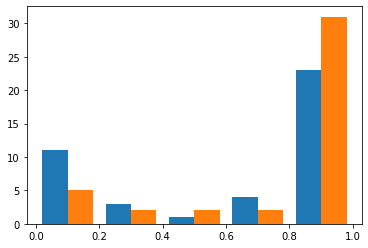

In [5]:
plt.hist([clf_probas[:,1], manual_probas], bins=5,range=(0,1))
plt.show

standard deviation calculation

In [6]:
np.square(np.subtract(clf_probas[:,1], manual_probas)).mean()

0.134058140294953

ROC AUC calculation

In [7]:
roc_auc_score(manual_preds, clf_probas[:,1])

0.9224489795918367

<function matplotlib.pyplot.show(close=None, block=None)>

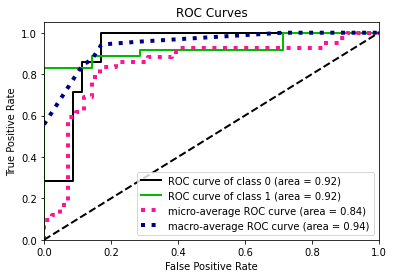

In [8]:
plot_roc(y_true=manual_preds, y_probas=clf_probas)
plt.show

# Independent test-set

In [9]:
independent = pd.read_csv('Independent.csv', index_col=0).set_index('Unnamed: 0.1').sort_index()

manual_probas = [float(p) for p in list(independent.y_probas)]
manual_preds = [int(p + 0.5) for p in manual_probas]

In [10]:
audio_path = '/Audio_recordings/'
emb_path = '/embs_normalized_5sec_5hops/'

patients = []
for root, dirs, files in os.walk(audio_path):
    for d in dirs:
        if '-' not in d and 3001 <= float(d) <= 3110:
            patients.append(d)
            
audio_folders = []
rnd = 0
for patient in patients:
    for root, dirs, files in os.walk(audio_path + '/' + patient):
        rnd += 1
        for d in dirs:
            random.seed(rnd)
            rand_d = random.choice(dirs)
            if rand_d == d:
                audio_folders.append(audio_path + '/' + patient + '/' + d + '/')

audio_files = []
emb_files = []
for folder in audio_folders:
    for root, dirs, files in os.walk(folder):
        for f in files:
            if 'ough' in f:
                audio_file = folder + f
                audio_files.append(audio_file)
                emb_file = audio_file.replace(audio_path, emb_path).split('.')[0] + '.npy'
                emb_files.append(emb_file)
                
filenames = [f.split('.')[0].split('/')[-1] for f in emb_files]

array = np.empty(shape=(0, 512))
for file in emb_files:
    emb_f = np.load(file, encoding='ASCII')
    if emb_f.shape[0] == 1:
        array = np.concatenate((array, emb_f))
    else:
        array = np.concatenate((array, np.average(emb_f, axis=0).reshape(1, -1)))
        
i_embs = pd.DataFrame(array, index = filenames, 
                      columns=['feature_' + str(i + 1) for i in range(512)]).sort_index()

clf_preds = clf.predict(i_embs)
clf_probas = clf.predict_proba(i_embs)

testing

<function matplotlib.pyplot.show(close=None, block=None)>

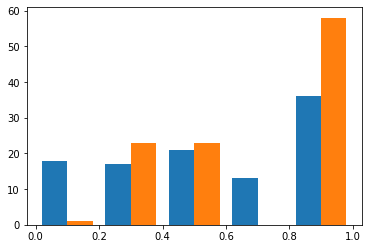

In [11]:
plt.hist([clf_probas[:,1], manual_probas], bins=5,range=(0,1))
plt.show

standard deviation calculation

In [12]:
np.square(np.subtract(clf_probas[:,1], manual_probas)).mean()

0.0982928651696978

ROC AUC calculation

In [13]:
roc_auc_score(manual_preds, clf_probas[:,1])

0.8986625514403292

<function matplotlib.pyplot.show(close=None, block=None)>

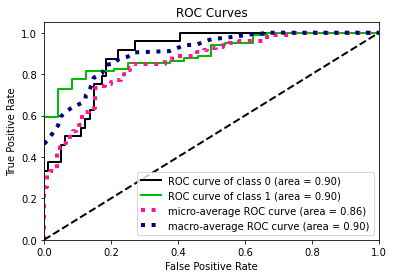

In [14]:
plot_roc(y_true=manual_preds, y_probas=clf_probas)
plt.show

In [15]:
pearsonr(clf_probas[:,1], manual_probas)[-1] < 0.005

True

p-value calculation

In [16]:
"{:.12f}".format(pearsonr(clf_probas[:,1], manual_probas)[-1])

'0.000000000001'